## Clonando o repositório com os dados do problema

In [ ]:
!rm -r IEC.PUC.Modelo.Notif.Dengue
!git clone https://github.com/cgalmeida/IEC.PUC.Modelo.Notif.Dengue.git

Cloning into 'IEC.PUC.Modelo.Notif.Dengue'...
remote: Enumerating objects: 858, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 858 (delta 21), reused 56 (delta 6), pack-reused 768
Receiving objects: 100% (858/858), 102.55 MiB | 13.44 MiB/s, done.
Resolving deltas: 100% (221/221), done.
Checking out files: 100% (566/566), done.


## Instalando o otimizador

In [ ]:
! pip install adabelief-tf --quiet

## Fazendo os imports das libs necessárias

In [ ]:
import os
from io import StringIO
import codecs
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow import keras
from adabelief_tf import AdaBeliefOptimizer
import random as python_random

## Especificando o caminho para os dados

In [ ]:
path_data = os.path.join('IEC.PUC.Modelo.Notif.Dengue', 'dados')
path_data

'IEC.PUC.Modelo.Notif.Dengue/dados'

In [ ]:
path_base = os.path.join('IEC.PUC.Modelo.Notif.Dengue', 'dados', 'metadados')
path_base

'IEC.PUC.Modelo.Notif.Dengue/dados/metadados'

## Lendo os dados e armazenando em uma lista

In [ ]:
def only_files(path):
    for file in os.listdir(path):
        if os.path.isfile(os.path.join(path, file)):
            yield file

def break_test(s):
    return 'SINAN NET' not in s.upper()

def read_file(file_path, line_pos):
    fp = codecs.open(file_path, 'r', encoding='latin-1')
    txt_lines = fp.readlines()[line_pos:]
    md = [s for s in txt_lines]
    data_lines = list(itertools.takewhile(break_test, txt_lines))
    fp.close()
    return data_lines

def to_dataframe(lst):
    return pd.read_csv(StringIO(''.join(lst)), sep=';', encoding = "latin-1")

def create_col_year(df, filename_var):
    df = df.replace('-', '0')
    df['Ano'] = filename_var[-8:-4]
    return df.drop(columns=['Total'])

def read_folder(path_data, filename_var):
    files = list(only_files(path_data))
    files.sort()    
    return [create_col_year(to_dataframe(read_file(os.path.join(path_data, file_name), 3)), file_name) for file_name in files if filename_var in file_name]

def read_base(filename_var):
    file_path = os.path.join(path_base, filename_var) + '.csv'
    return pd.read_csv(file_path, sep=';', encoding = "ISO-8859-1")

def merge_base(df_data, df_base):
    df_data.columns.values[0] = 'Descricao'
    return pd.merge(df_data, df_base, on='Descricao', how='inner')

def transpose_data(df):
    # df.set_index(['descricao','Ano','codigo']).stack().reset_index()
    return df.melt(id_vars=['Descricao','Ano','Codigo']).rename(columns={'variable':'Mes', 'value': 'Casos'})

def format_res(df):
    df_mes = read_base('mes_abr').rename(columns={'Codigo': 'Codigo_Mes', 'Descricao': 'Mes'})
    df_mes = pd.merge(df, df_mes, on=['Mes'], how='inner')
    df_mes['Periodo'] = df_mes.apply(lambda x: x.Ano + '.' + str(x.Codigo_Mes).zfill(2), axis=1)
    return df_mes

def type_col(df):
    df['Descricao'] = df['Descricao'].astype('str')
    df['Ano'] = df['Ano'].astype('int64')
    df['Mes'] = df['Mes'].astype('str')
    df['Casos'] = df['Casos'].astype('int64')
    df['Periodo'] = df['Periodo'].astype('str')
    return df

def prepare_data(path_data, filename_var):
    df_base = read_base(filename_var)
    res = [merge_base(i, df_base) for i in read_folder(path_data, filename_var)]
    res = [format_res(transpose_data(df)) for df in res]    
    res = pd.concat(res[:], axis=0).reset_index(drop=True)
    res = type_col(res)
    res = res.groupby(['Ano', 'Codigo', 'Codigo_Mes', 'Periodo'], group_keys=False).sum().reset_index()
    return pd.merge(res, df_base, on=['Codigo'], how='inner')

def totalizar(df):
    return df.groupby(['Ano', 'Codigo_Mes', 'Periodo'], group_keys=False).sum().reset_index().drop(columns=['Codigo'])

In [ ]:
%%time
filename_var = 'macrorregiao'
data_list = prepare_data(path_data, filename_var)
#data_list = data_list[data_list['MACRORREGIAO'] == 3101]
data_list = totalizar(data_list)
data_list.head()

CPU times: user 393 ms, sys: 7.31 ms, total: 400 ms
Wall time: 420 ms


,Ano,Codigo_Mes,Periodo,Casos
0,2007,1,2007.01,1625
1,2007,2,2007.02,3189
2,2007,3,2007.03,7899
3,2007,4,2007.04,8351
4,2007,5,2007.05,4547


In [ ]:
data = data_list['Casos'].values.tolist()

## Dados pluviométricos

In [ ]:
df_meteo = read_base('meteo_mg')
df_meteo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2520 entries, 0 to 2519
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ANO               2520 non-null   int64  
 1   MES               2520 non-null   int64  
 2   MACRORREGIAO      2520 non-null   int64  
 3   PRECIPITACAO      2520 non-null   float64
 4   PRESSAO_ATM       2520 non-null   float64
 5   TEMPERATURA       2520 non-null   float64
 6   UMIDADE_RELATIVA  2520 non-null   float64
dtypes: float64(4), int64(3)
memory usage: 137.9 KB


In [ ]:
def crt_period(df):
    ano = '{0:0>4}'.format(df.ANO)
    mes = '{0:0>2}'.format(df.MES)
    return ano + '.' + mes
df_meteo['Periodo'] = df_meteo.apply(crt_period, axis=1)
df_meteo['Periodo'] = df_meteo.apply(crt_period, axis=1)
df_meteo.sample(5)

,ANO,MES,MACRORREGIAO,PRECIPITACAO,PRESSAO_ATM,TEMPERATURA,UMIDADE_RELATIVA,Periodo
1401,2015,5,3112,0.117115,923.377195,20.069176,75.0,2015.05
1084,2013,7,3103,0.002212,920.380636,18.686962,68.0,2013.07
754,2011,7,3109,0.000067,924.228663,20.506116,54.0,2011.07
391,2009,5,3110,0.018809,938.511285,18.311755,81.0,2009.05
1608,2016,8,3109,0.004590,924.669852,23.329053,43.0,2016.08


In [ ]:
f = {'PRECIPITACAO':['sum'], 'PRESSAO_ATM':['mean'], 'TEMPERATURA':['mean'], 'UMIDADE_RELATIVA':['mean']}
df_meteo = df_meteo.groupby(['ANO', 'MES', 'Periodo'], group_keys=False).agg(f).reset_index()
df_meteo.columns = [i[0] for i in df_meteo.columns]
df_meteo.drop(columns=['ANO', 'MES'], inplace=True)

df_data = pd.merge(data_list, df_meteo, on='Periodo', how='inner')
df_data.drop(columns=['Ano', 'Codigo_Mes'], inplace=True)
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180 entries, 0 to 179
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Periodo           180 non-null    object 
 1   Casos             180 non-null    int64  
 2   PRECIPITACAO      180 non-null    float64
 3   PRESSAO_ATM       180 non-null    float64
 4   TEMPERATURA       180 non-null    float64
 5   UMIDADE_RELATIVA  180 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 9.8+ KB


In [ ]:
df_data.sample(5)

,Periodo,Casos,PRECIPITACAO,PRESSAO_ATM,TEMPERATURA,UMIDADE_RELATIVA
124,2017.05,3100,1.184647,935.824335,20.638091,74.500000
100,2015.05,56295,1.159049,933.752860,19.748816,78.571429
90,2014.07,1309,0.740222,936.824634,18.609911,70.428571
148,2019.05,156537,0.798072,934.945028,21.807068,74.928571
17,2008.06,2943,0.217084,935.643146,18.785202,72.357143


## Dando uma olhada no dataset

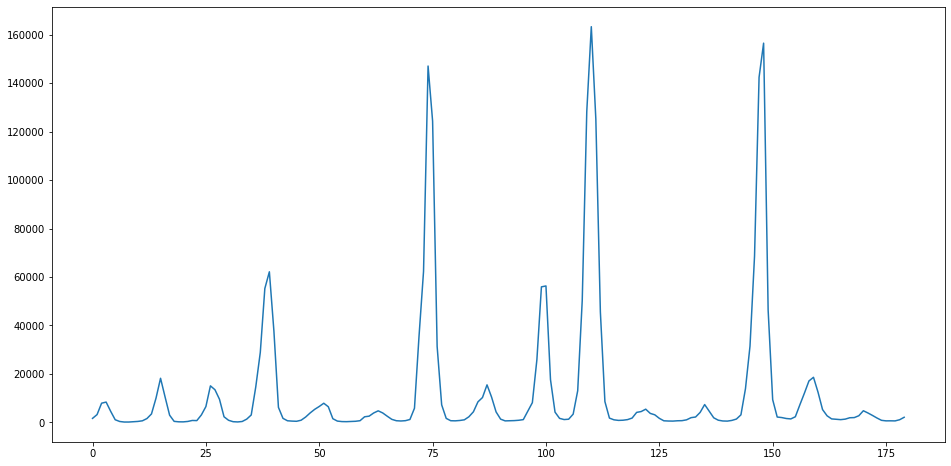

In [ ]:
%matplotlib inline
plt.figure(figsize=(16,8))
plt.plot(data)
plt.show()

## Processando o dado

In [ ]:
dataframe =  data_list['Casos']
dataset = dataframe.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform([[i] for i in dataset])

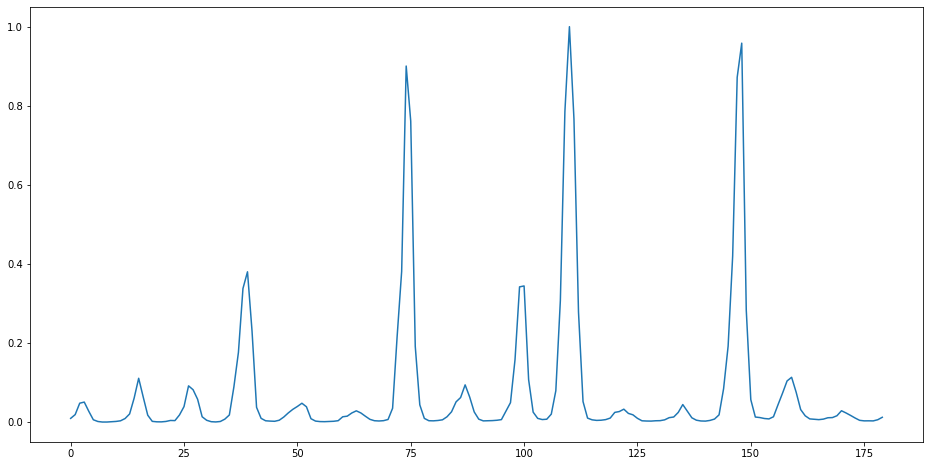

In [ ]:
%matplotlib inline
plt.figure(figsize=(16,8))
plt.plot(dataset)
plt.show()

## "Aumentando o dado" 

A quantidade de observações da série é pequena, em torno de 100.

Necessita-se aumentar artificialmente a série para melhor avaliar e treinar o modelo.

In [ ]:
! pip install tsaug --quiet

(<Figure size 1152x144 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7efd444f7450>)

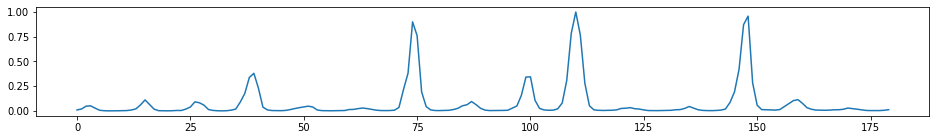

In [ ]:
from tsaug.visualization import plot as plt_au

use_aug = False
d_test = dataset.reshape(1, 180).flat[0:180]
plt_au(d_test)

(<Figure size 1152x144 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7efd446260d0>)

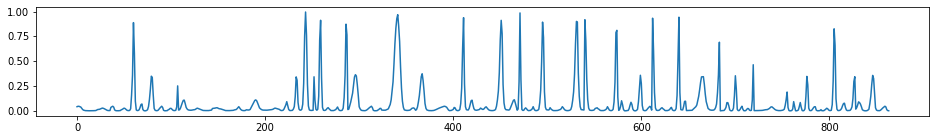

In [ ]:
from tsaug import TimeWarp, Crop, Quantize, Drift, Reverse

repeat = 24
d_test = dataset.reshape(1, 180).flat[0:180]
my_augmenter = (TimeWarp() * repeat
                + Crop(size=36)
)
new_data = my_augmenter.augment(d_test)
len_data = len(new_data[0]) * repeat
d_test = new_data.reshape(1, len_data).flat[0:len_data]
plt_au(np.array(d_test))

In [ ]:
if use_aug:
  dataset = np.array([[i] for i in d_test])
  dataset.shape

## Separando o dado em treino e teste

In [ ]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

In [ ]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

def plot_convergence(hist: tf.keras.callbacks.History, 
                     metric_name:str) -> None:
  figure = plt.gcf()
  figure.set_size_inches((15, 5))
  figure.patch.set_facecolor('darkgrey')
  
  ax = plt.axes()
  ax.set_facecolor("darkgrey")
  
  plt.xlabel('Epoch', fontsize=14)
  plt.xticks(fontsize=14)
  plt.ylabel(metric_name.title(), fontsize=14)
  plt.yticks(fontsize=14)

  plt.plot(range(1, len(hist.history[metric_name.lower()]) + 1), 
           hist.history[metric_name.lower()], marker='o', linewidth=3, 
           markersize=12)
  plt.plot(range(1, len(hist.history[f'val_{metric_name.lower()}']) + 1), 
           hist.history[f'val_{metric_name.lower()}'], marker='X', linewidth=3, 
           markersize=12)
  plt.legend([metric_name.title(), f'Validation {metric_name.title()}'], 
             fontsize=14)
  plt.show()

def reset_seeds():
   np.random.seed(123) 
   python_random.seed(123)
   tf.random.set_seed(1234)

In [ ]:
learning_rate = 1e-3
ada_belief = AdaBeliefOptimizer(learning_rate=learning_rate, print_change_log = False)

## Preparando o dado

In [ ]:
look_back = 12
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

## Criando, compilando e treinando o modelo de Redes Neurais Recorrentes

In [ ]:
%%time
reset_seeds() 
model = Sequential()
model.add(LSTM(30, return_sequences=True, input_shape=(1, look_back)))
model.add(LSTM(30))
model.add(Dense(1))


In [ ]:
model.compile(loss='mean_squared_error', 
              optimizer=ada_belief)

In [ ]:
hist = model.fit(trainX,
                 trainY,
                 epochs=400,
                 batch_size=128,
                 validation_split=0.2)

## Plotando a convergência

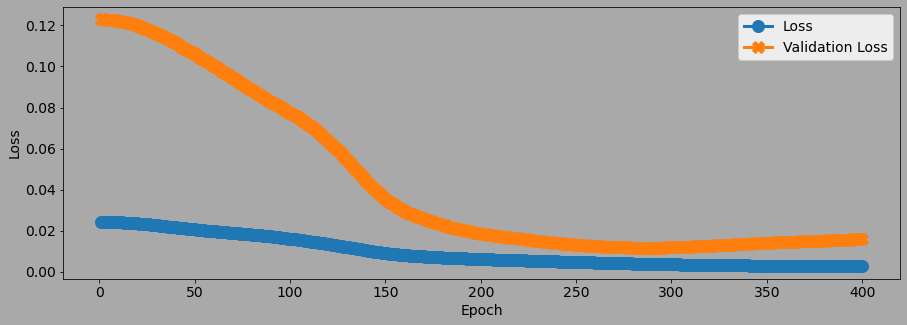

In [ ]:
plot_convergence(hist, 'loss')

## Fazendo as predições para os dados

In [ ]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict_v = scaler.inverse_transform(trainPredict)
trainY_v = scaler.inverse_transform([trainY])
testPredict_v = scaler.inverse_transform(testPredict)
testY_v = scaler.inverse_transform([testY])

trainScore = np.sqrt(mean_squared_error(trainY_v[0], trainPredict_v[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY_v[0], testPredict_v[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

In [ ]:
trainScore

11851.69441539605

In [ ]:
testScore

9280.857494540578

In [ ]:
mean_squared_error(trainY, trainPredict, squared=True)

0.00527266431046954

## Vendo a série prevista pela rede

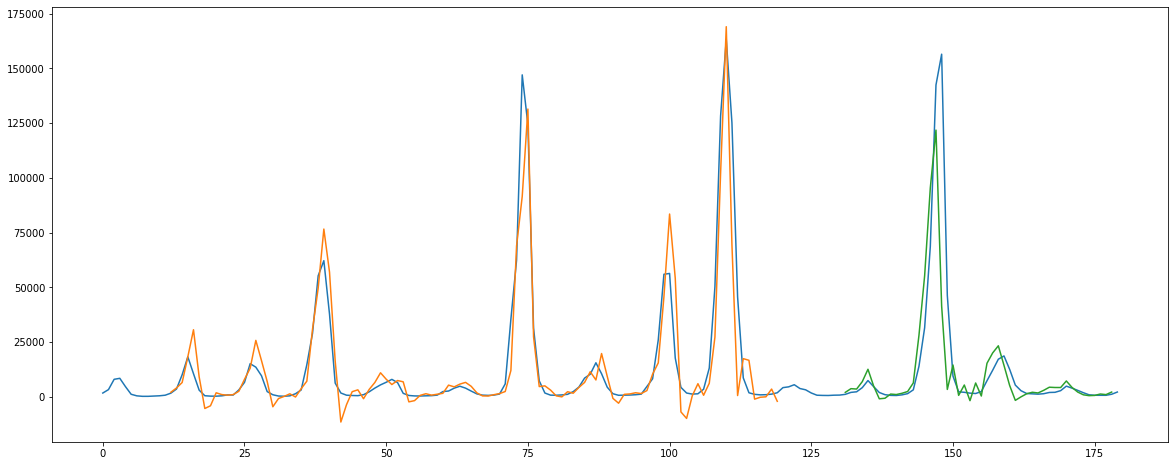

In [ ]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)-1:len(dataset)-1, :] = testPredict

plt.figure(figsize=(20,8))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## Fazendo a previsão para um período futuro (em meses)

In [ ]:
def create_forecast(model_fc, init_data, period=12):
    new_data = []
    new_test = list(init_data)
    for i in range(period):
        test_item = np.array([[new_test]])
        p_val = model_fc.predict(test_item)
        new_test = new_test[1:look_back] + [p_val[0][0]]
        new_data.append(new_test)
    return new_data

lastX = testX[testX.shape[0]-1][0]
predX = create_forecast(model, lastX)
new_testX = np.array(predX)
new_testX = np.reshape(new_testX, (new_testX.shape[0], 1, new_testX.shape[1]))
new_testX = np.append(testX, new_testX, axis=0)

repeat = new_testX.shape[0] - testX.shape[0]
new_dataset = np.append(dataset, [[i] for i in np.repeat(0, repeat)], axis=0)

1/1 [==============================] - 0s 19ms/step


2/2 [==============================] - 0s 7ms/step
108
25
133


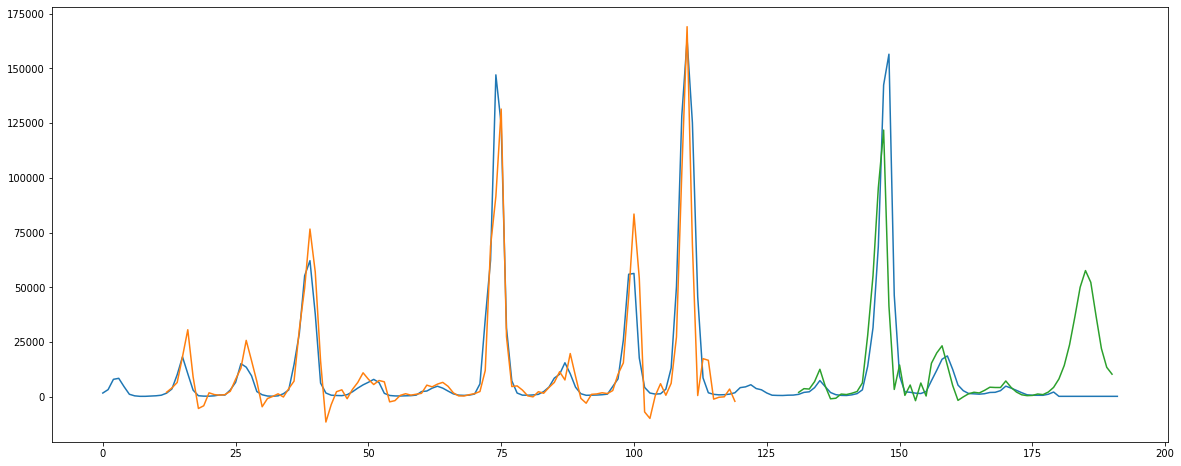

In [ ]:
trainPredict = model.predict(trainX)
testPredict = model.predict(new_testX)

trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

trainPredictPlot = np.empty_like(new_dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.empty_like(new_dataset)
testPredictPlot[:, :] = np.nan
print(len(trainPredict))
print((look_back*2)+1)
print(len(trainPredict)+(look_back*2)+1)
testPredictPlot[len(trainPredict)+(look_back*2)-1:len(new_dataset)-1, :] = testPredict

plt.figure(figsize=(20,8))
plt.plot(scaler.inverse_transform(new_dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## Modelo autokeras

In [ ]:
! pip install autokeras --quiet

In [ ]:
dataframe =  data_list['Casos']
dataset = dataframe.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform([[i] for i in dataset])

In [ ]:
train_size = int(len(dataset) * 0.67)
validation_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

120 60


In [ ]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

#trainX = np.reshape(trainX, (trainX.shape[0], 1))
#testX = np.reshape(testX, (testX.shape[0], 1))

In [ ]:
from  autokeras import TimeseriesForecaster

predict_from = 1
predict_until = 10
model_clf = TimeseriesForecaster(
    lookback=12,
    predict_from=predict_from,
    predict_until=predict_until,
    max_trials=1,
    objective="val_loss"
)
# Train the TimeSeriesForecaster with train data
model_clf.fit(
    x=trainX,
    y=trainY,
    validation_data=(testX, testY),
    batch_size=32,
    epochs=100
)

# Evaluate the best model with testing data.
print(model_clf.evaluate(testX, testY))

AttributeError: ignored

In [ ]:
best_model = model_clf.export_model()
best_model.summary()

In [ ]:
best_model.fit(
    x=trainX,
    y=trainY,
    validation_data=(testX, testY),
    batch_size=32,
    epochs=100
)

In [ ]:
plot_convergence(best_model.history, "loss")

In [ ]:
trainPredict = best_model.predict(trainX)
testPredict = best_model.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

In [ ]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)-1:len(dataset)-1, :] = testPredict

plt.figure(figsize=(20,8))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## Facebook Prophet

In [ ]:
! pip install sktime --quiet

In [ ]:
from sktime.forecasting.fbprophet import Prophet

# Prophet requires to have data with a pandas.DatetimeIndex

y = pd.DataFrame(data=dataset, index=pd.date_range(start='2007-01-01', end='2021-12-31', freq='M'))

forecaster = Prophet(  
    seasonality_mode='additive',
    n_changepoints=int(len(y) / 12),
    add_country_holidays={'country_name': 'Germany'},
    yearly_seasonality='auto')

forecaster.fit(y)
period = list(range(1,13))
y_pred = forecaster.predict(fh=period)  

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp05nb8jd0/hwv9eh25.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp05nb8jd0/q2i5x2hz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91455', 'data', 'file=/tmp/tmp05nb8jd0/hwv9eh25.json', 'init=/tmp/tmp05nb8jd0/q2i5x2hz.json', 'output', 'file=/tmp/tmp05nb8jd0/prophet_modelhnveto5x/prophet_model-20221019211937.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:19:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:19:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


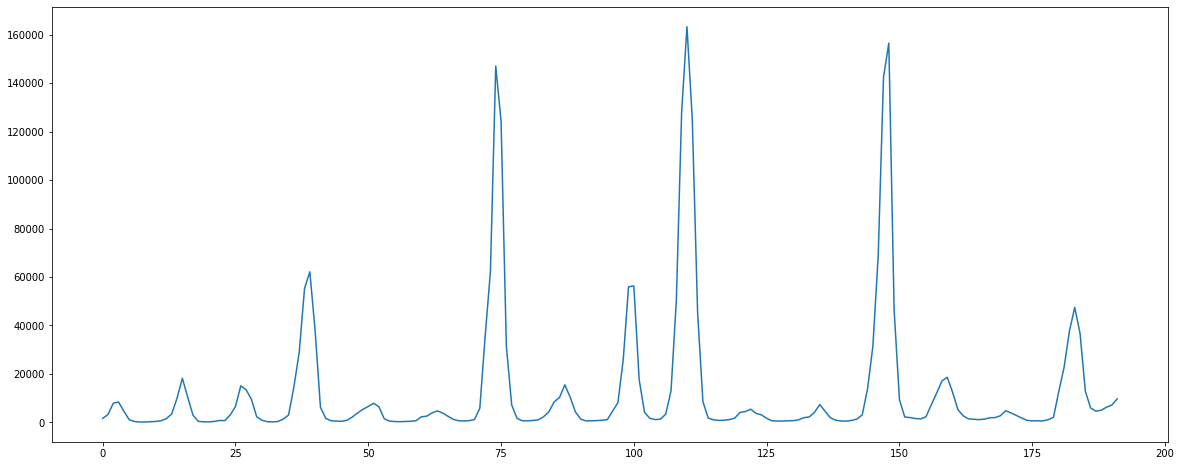

In [ ]:
from matplotlib import pyplot as plt

y_final = pd.concat([y, y_pred])
y_final = [[i] for i in y_final[0].to_numpy()]

plt.figure(figsize=(20,8))
plt.plot(scaler.inverse_transform(y_final))

In [ ]:
from sktime.utils.plotting import plot_series

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp05nb8jd0/me8ytlkm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp05nb8jd0/mekym_h3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46006', 'data', 'file=/tmp/tmp05nb8jd0/me8ytlkm.json', 'init=/tmp/tmp05nb8jd0/mekym_h3.json', 'output', 'file=/tmp/tmp05nb8jd0/prophet_model4d_3okss/prophet_model-20221019212823.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:28:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:28:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7faeadbc88d0>)

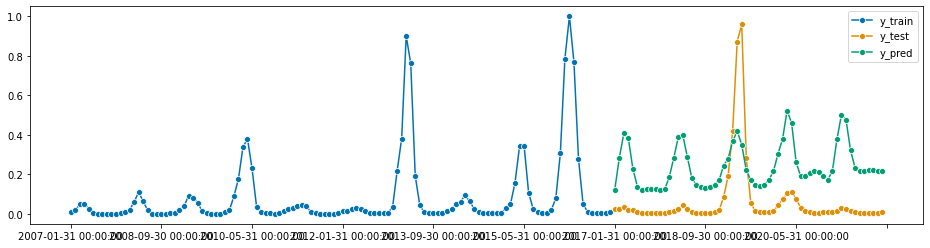

In [ ]:
from sktime.forecasting.fbprophet import Prophet
from sktime.forecasting.model_selection import temporal_train_test_split

# Prophet requires to have data with a pandas.DatetimeIndex

y = pd.DataFrame(data=dataset, index=pd.date_range(start='2007-01-01', end='2021-12-31', freq='M'))

y_train, y_test = temporal_train_test_split(y, test_size=60)

forecaster = Prophet(  
    seasonality_mode='additive',
    changepoint_prior_scale=0.2,
    n_changepoints=int(len(y_train) / 12),
    add_country_holidays={'country_name': 'Germany'},
    yearly_seasonality='auto')

forecaster.fit(y_train)
period = list(range(1,len(y_test) + 1))
y_pred = forecaster.predict(fh=period)

# plotting for illustration
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

In [ ]:
val_y_test = scaler.inverse_transform(y_test)
val_y_pred = scaler.inverse_transform(y_pred)
print(mean_squared_error(val_y_test, val_y_pred, squared=True))
print(mean_squared_error(y_test, y_pred, squared=True))


1584073820.748885
0.05946270127952983


## TBAT - Modelo estatístico

In [ ]:
! pip install tbats --quiet

In [ ]:
from sktime.forecasting.tbats import TBATS

y = pd.DataFrame(data=dataset, index=pd.date_range(start='2007-01-01', end='2021-12-31', freq='M'))

forecaster = TBATS(  
    use_box_cox=False,
    use_trend=True,
    use_damped_trend=False,
    sp=12,
    use_arma_errors=False,
    n_jobs=1)

forecaster.fit(y)  

period = list(range(1,13))
y_pred = forecaster.predict(fh=period)

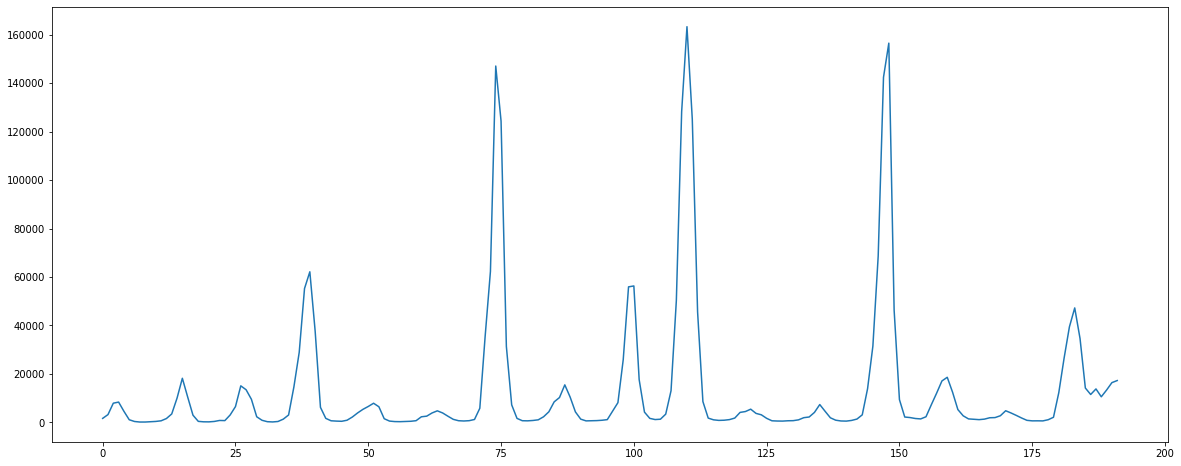

In [ ]:
from matplotlib import pyplot as plt

y_final = pd.concat([y, y_pred])
y_final = [[i] for i in y_final[0].to_numpy()]

plt.figure(figsize=(20,8))
plt.plot(scaler.inverse_transform(y_final))

## SARIMAX - Modelo estatístico

In [ ]:
from sktime.forecasting.sarimax import SARIMAX

forecaster = SARIMAX(order=(1, 0, 0), trend="t", seasonal_order=(1, 0, 0, 6))

y = pd.DataFrame(data=dataset, index=pd.date_range(start='2007-01-01', end='2021-12-31', freq='M'))

forecaster.fit(y)

p_idx = pd.date_range(start='2022-01-01', end='2022-12-31', freq='M')

y_pred = forecaster.predict(fh=p_idx)


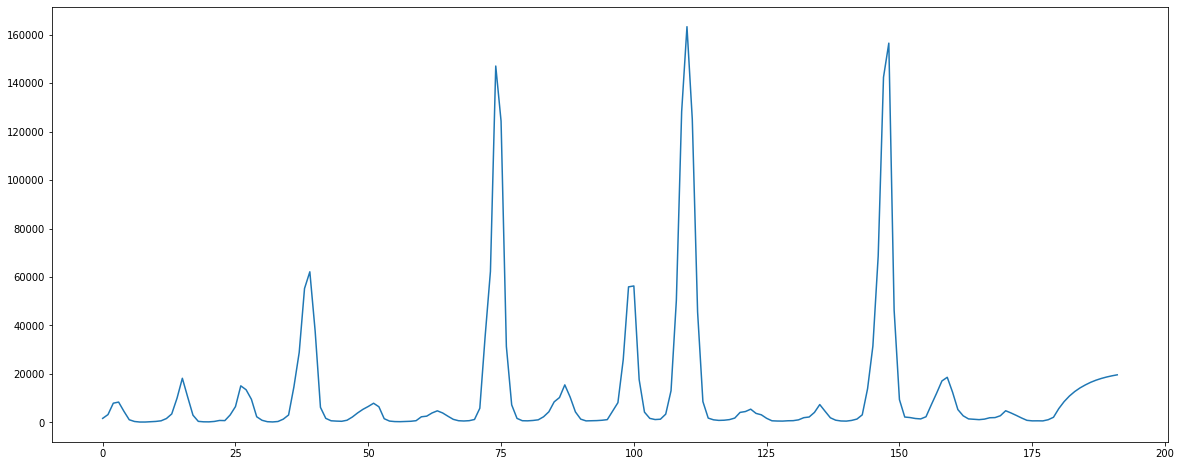

In [ ]:
from matplotlib import pyplot as plt

y_final = pd.concat([y, y_pred])
y_final = [[i] for i in y_final[0].to_numpy()]

plt.figure(figsize=(20,8))
plt.plot(scaler.inverse_transform(y_final))

## Exponential Smoothing

In [ ]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

y = pd.DataFrame(data=dataset, index=pd.date_range(start='2007-01-01', end='2021-12-31', freq='M'))

forecaster = ExponentialSmoothing(trend='add', seasonal='additive', sp=36)
forecaster.fit(y)

period = list(range(1,13))
y_pred = forecaster.predict(fh=period)

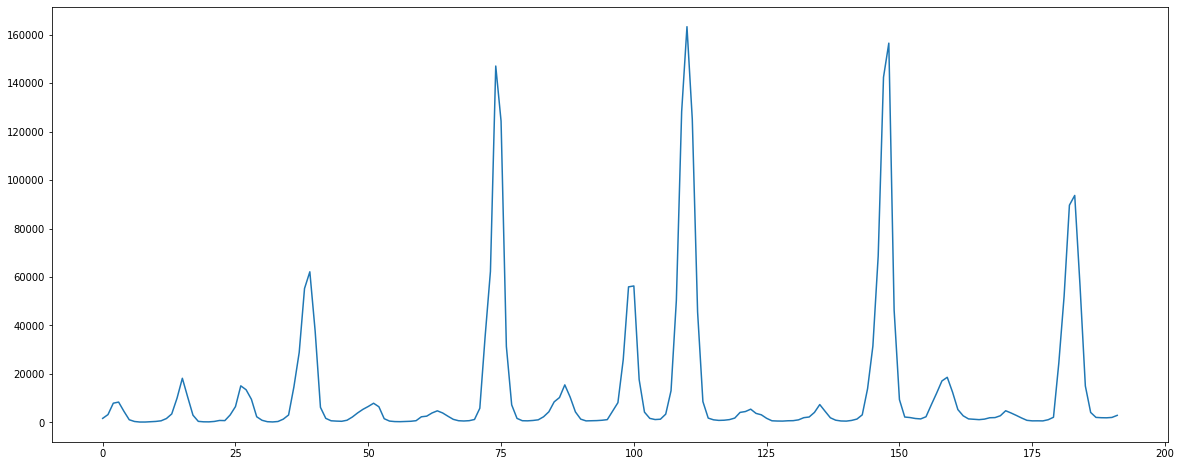

In [ ]:
from matplotlib import pyplot as plt

y_final = pd.concat([y, y_pred])
y_final = [[i] for i in y_final[0].to_numpy()]

plt.figure(figsize=(20,8))
plt.plot(scaler.inverse_transform(y_final))

(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fae9c6ee6d0>)

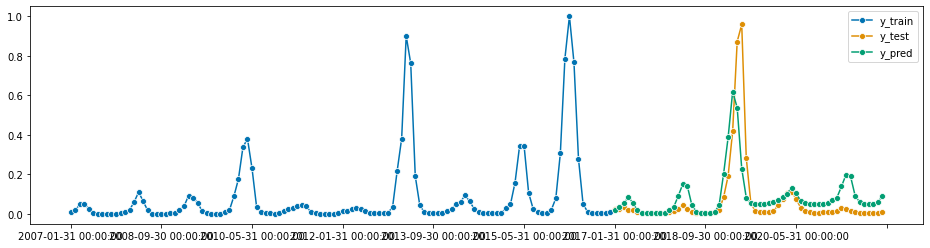

In [ ]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.model_selection import temporal_train_test_split

# Prophet requires to have data with a pandas.DatetimeIndex

y = pd.DataFrame(data=dataset, index=pd.date_range(start='2007-01-01', end='2021-12-31', freq='M'))

y_train, y_test = temporal_train_test_split(y, test_size=60)

forecaster = ExponentialSmoothing(trend='add', seasonal='additive', sp=36)

forecaster.fit(y_train)
period = list(range(1,len(y_test) + 1))
y_pred = forecaster.predict(fh=period)

# plotting for illustration
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

In [ ]:
val_y_test = scaler.inverse_transform(y_test)
val_y_pred = scaler.inverse_transform(y_pred)
print(mean_squared_error(val_y_test, val_y_pred, squared=True))
print(mean_squared_error(y_test, y_pred, squared=True))

418577061.9142391
0.01571247657088533


## Auto ETS

In [ ]:
from sktime.forecasting.ets import AutoETS

y = pd.DataFrame(data=dataset, index=pd.date_range(start='2007-01-01', end='2021-12-31', freq='M'))

forecaster = AutoETS(auto=True, n_jobs=-1, sp=12)
forecaster.fit(y)

period = list(range(1,13))
y_pred = forecaster.predict(fh=period)


/usr/local/lib/python3.7/dist-packages/sktime/forecasting/ets.py:252: UserWarning: Warning: time series is not strictly positive, multiplicative components are ommitted
  "Warning: time series is not strictly positive, "


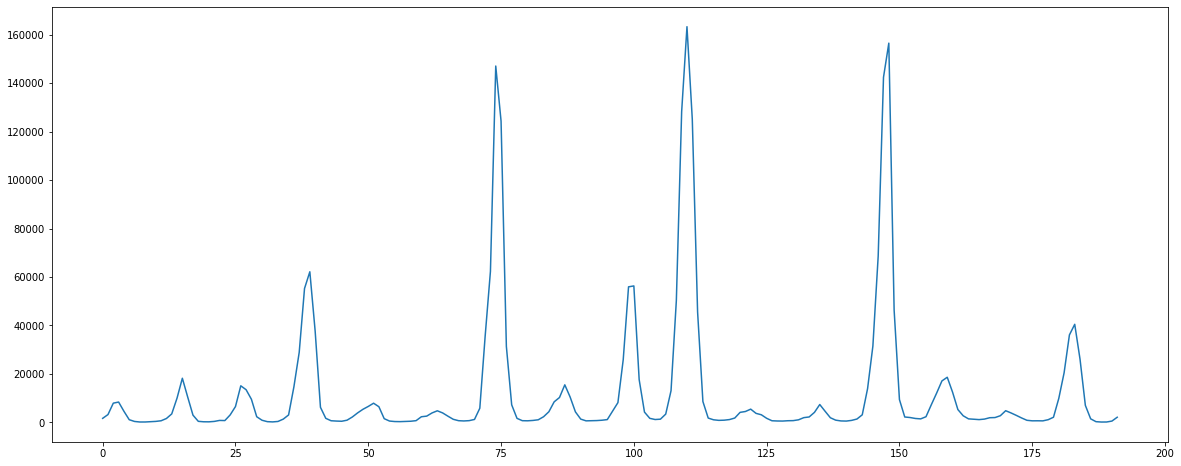

In [ ]:
from matplotlib import pyplot as plt

y_final = pd.concat([y, y_pred])
y_final = [[i] for i in y_final[0].to_numpy()]

plt.figure(figsize=(20,8))
plt.plot(scaler.inverse_transform(y_final))

## Rede Neural - Teste com dataset organizado de modo sazonal

In [ ]:
def create_season_dataset(dataset, look_back=1, n_season=12):
		if len(dataset) % n_season != 0:
				raise Exception("Error: dataset lenght must be divided by 'n_season' parameter!") 
		dataX, dataY = [], []
		for i in range(len(dataset) - (n_season * look_back)):
				X = []
				for j in range(look_back):
						X.append(dataset[i+(j*n_season)])
				y = dataset[i+(n_season * look_back)]
				dataX.append(X)
				dataY.append(y)
		return np.array(dataX), np.array(dataY)

In [ ]:
learning_rate = 1e-3
ada_belief = AdaBeliefOptimizer(learning_rate=learning_rate, print_change_log = False)

In [ ]:
val_seasons = 12
n_sets = len(dataset) / val_seasons
train_size = int(n_sets * 0.67) * val_seasons
test_size = len(dataset) - train_size
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]
print(len(train), len(test))

In [ ]:
look_back = 4
trainX, trainY = create_season_dataset(train, look_back)
testX, testY = create_season_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print(trainX.shape)
print(testX.shape)

In [ ]:
%%time
reset_seeds() 
model = Sequential()
model.add(LSTM(30, return_sequences=True, input_shape=(1, look_back)))
model.add(LSTM(30, return_sequences=True))
model.add(LSTM(30))
model.add(Dense(1))

model.compile(loss='mean_squared_error', 
              optimizer=ada_belief)

hist = model.fit(trainX,
                 trainY,
                 epochs=50,
                 batch_size=64,
                 validation_split=0.2)

In [ ]:
plot_convergence(hist, 'loss')

In [ ]:
testX, testY = create_season_dataset(dataset, look_back)
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
testPredict = model.predict(testX)

testPredict = scaler.inverse_transform(testPredict)

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[(look_back*val_seasons)-1:len(dataset)-1, :] = testPredict

plt.figure(figsize=(20,8))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(testPredictPlot)
plt.show()

## Valores futuros

In [ ]:
n_period = 1
fut_val = np.array([[i] for i in np.repeat(0, val_seasons * n_period)])
new_dataset = np.concatenate((dataset, fut_val), axis=0)
testX, testY = create_season_dataset(new_dataset, look_back)
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
testPredict = model.predict(testX)

testPredict = scaler.inverse_transform(testPredict)

testPredictPlot = np.empty_like(new_dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[(look_back*val_seasons)-1:len(new_dataset)-1, :] = testPredict

plt.figure(figsize=(20,8))
plt.plot(scaler.inverse_transform(new_dataset))
plt.plot(testPredictPlot)
plt.show()

## Previsão com dados meteorológicos

In [ ]:
! pip install dtw-python --quiet
! pip install pyod --quiet
! pip install hmmlearn --quiet
! pip install tsfresh --quiet
! pip install esig --quiet
! pip install tslearn --quiet
! pip install statsforecast --quiet
! pip install mne --quiet
! pip install pykalman --quiet
! pip install filterpy --quiet
! pip install stumpy --quiet

In [ ]:
from sktime.registry import all_estimators

for forecaster in all_estimators(filter_tags={"scitype:y": ["multivariate", "both"]}):
    print(forecaster[0])

ERROR:numba.cuda.cudadrv.driver:Call to cuInit results in CUDA_ERROR_NO_DEVICE


In [ ]:
df_data.sample(5)

,Periodo,Casos,PRECIPITACAO,PRESSAO_ATM,TEMPERATURA,UMIDADE_RELATIVA
57,2011.10,348,3.174717,930.829019,21.553030,73.500000
65,2012.06,2513,0.700439,935.255022,19.755323,75.500000
71,2012.12,5801,2.053104,929.568096,24.585446,70.357143
10,2007.11,365,3.054137,930.124480,23.253862,70.285714
70,2012.11,1170,5.478016,929.144507,22.406874,78.428571


In [ ]:
df = df_data.copy()
df['Datetime'] = pd.to_datetime(df['Periodo'] + '.01')
df = df.set_index('Datetime')
df = df.drop(['Periodo'], axis=1)
df.tail()

,Casos,PRECIPITACAO,PRESSAO_ATM,TEMPERATURA,UMIDADE_RELATIVA
Datetime,,,,,
2021-08-01,602,0.155424,938.003747,20.716058,61.285714
2021-09-01,617,0.412160,934.963957,24.666046,57.642857
2021-10-01,586,3.182318,934.439845,23.560383,71.142857
2021-11-01,1068,4.537954,932.344418,22.795086,73.500000
2021-12-01,2082,5.572109,931.400529,22.587740,78.714286


In [ ]:
from sktime.forecasting.model_selection import temporal_train_test_split

y_all = df
y_train, y_test = temporal_train_test_split(y_all, test_size=60)

(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fae8f4730d0>)

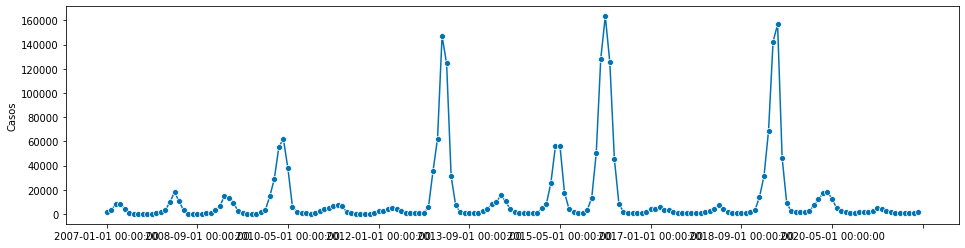

In [ ]:
from sktime.utils.plotting import plot_series

# plotting for visualization
plot_series(y_all['Casos'])

(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fae8e8b0050>)

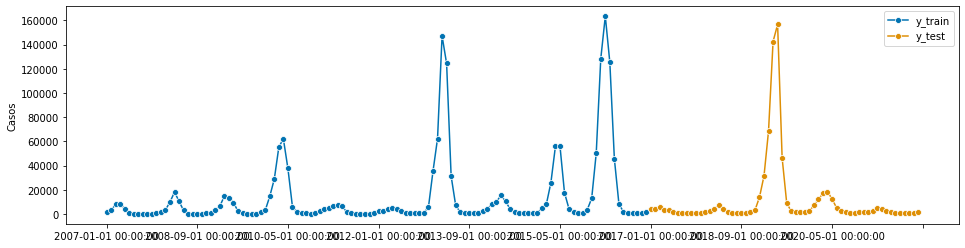

In [ ]:
from sktime.utils.plotting import plot_series

# plotting for illustration
plot_series(y_train['Casos'], y_test['Casos'], labels=["y_train", "y_test"])

In [ ]:
# Horizonte de previsão
p_tst = pd.date_range(start='2017-01-01', end='2021-12-31', freq='M')
p_idx = pd.date_range(start='2022-01-01', end='2022-12-31', freq='M')
p_idx

DatetimeIndex(['2022-01-31', '2022-02-28', '2022-03-31', '2022-04-30',
               '2022-05-31', '2022-06-30', '2022-07-31', '2022-08-31',
               '2022-09-30', '2022-10-31', '2022-11-30', '2022-12-31'],
              dtype='datetime64[ns]', freq='M')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fae8e718b50>)

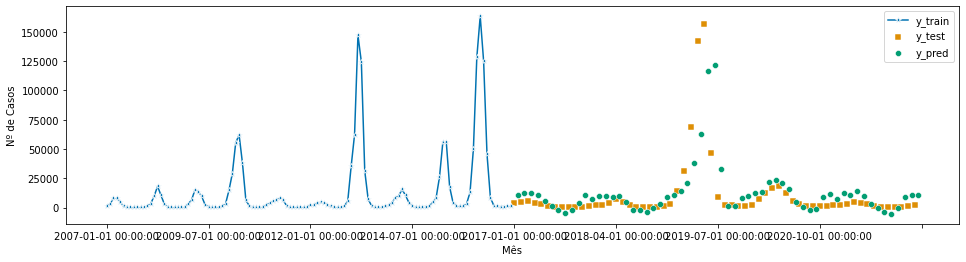

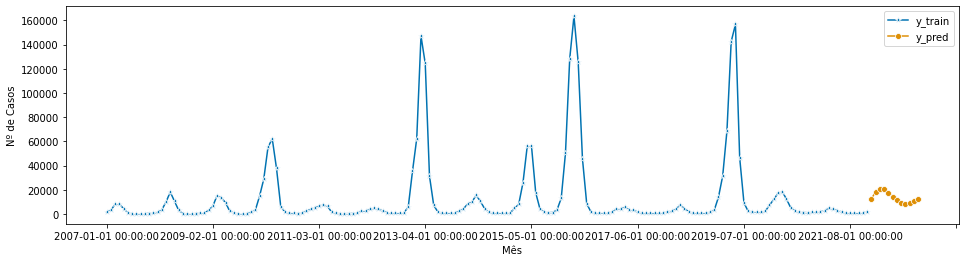

In [ ]:
from sktime.forecasting.var import VAR

forecaster = VAR()

# Avaliação
y = y_all
forecaster.fit(y)
y_pred = forecaster.predict(fh=p_tst)
plot_series(y_train['Casos'], y_test['Casos'], y_pred['Casos'], labels=["y_train", "y_test", "y_pred"], x_label='Mês', y_label='Nº de Casos', markers=['*', 's', 'o'])

# 2022
y = y_all
forecaster.fit(y)
y_pred2 = forecaster.predict(fh=p_idx)
plot_series(y_all['Casos'], y_pred2['Casos'], labels=["y_train", "y_pred"], x_label='Mês', y_label='Nº de Casos', markers=['*', 'o'])


In [ ]:
val_y_test = scaler.inverse_transform(y_test)
val_y_pred = scaler.inverse_transform(y_pred)
mean_squared_error(val_y_test, val_y_pred, squared=True)

1.5255851819231265e+18

In [ ]:
mean_squared_error(y_test, y_pred, squared=True)

57267164.42184843